In [45]:
import os
import glob
import IPython.display as ipd
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Subtract
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from keras.initializers import RandomNormal

from tqdm.notebook import tqdm
from pprint import pprint

In [46]:
DATA_DIR = Path('./frgc32x32/')
images = [x.name for x in DATA_DIR.glob('*')]

In [47]:
paths_all_labels = []
for image in images:
    x = image.split("d", 1)
    paths_all_labels.append((x[0], './frgc32x32/'+image))

In [48]:
import pandas as pd

In [49]:
image_paths = list(DATA_DIR.glob('*.png'))
user_id = [x.name.split('d')[0] for x in image_paths]
user_img_id = [x.name.split('d')[1].replace('.png', '') for x in image_paths]

directory_df = pd.DataFrame({
    'user_id': user_id,
    'user_img_id': user_img_id,
    'path': [str(x) for x in image_paths]
})

In [50]:
(    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
     .describe()
)

,count
count,568.000000
mean,21.667254
std,16.794857
min,2.000000
25%,8.000000
50%,18.000000
75%,32.000000
max,70.000000


<AxesSubplot:xlabel='user_id'>

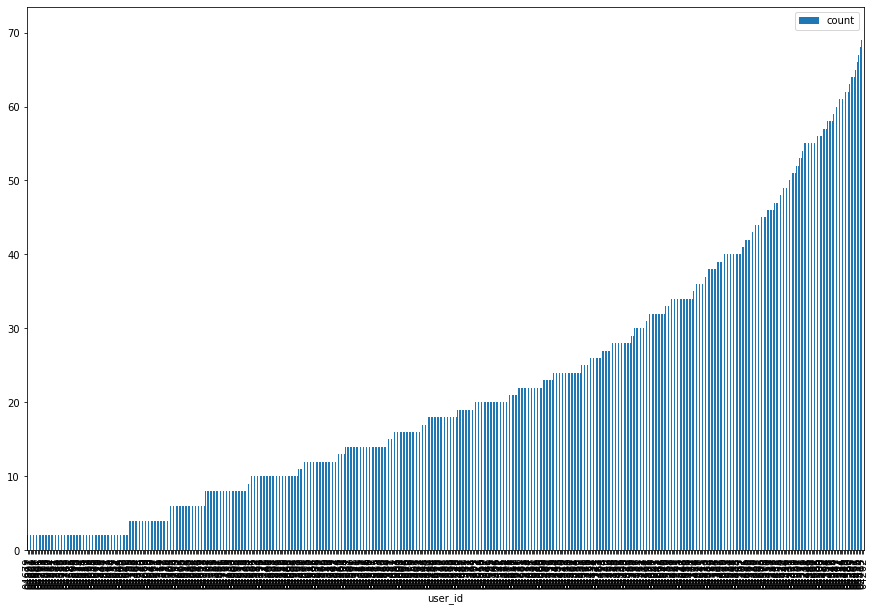

In [51]:
(
    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [52]:
data_size = 20

ids_to_keep = ( 
    directory_df
    .groupby('user_id')['user_img_id']
    .count() >= data_size
)
ids_to_keep = ids_to_keep[ids_to_keep].index

subset_directory_df = (
    directory_df
    .loc[directory_df['user_id'].isin(ids_to_keep)]
    .sample(frac=1)
    .groupby('user_id')
    .head(data_size)
    .copy()
)

old_unique = directory_df['user_id'].nunique()
new_unique = subset_directory_df['user_id'].nunique()
print(f"There are {new_unique}/{old_unique} ({new_unique/old_unique*100:.2f}%)" +
      " unique IDs remaining.")

There are 265/568 (46.65%) unique IDs remaining.


<AxesSubplot:xlabel='user_id'>

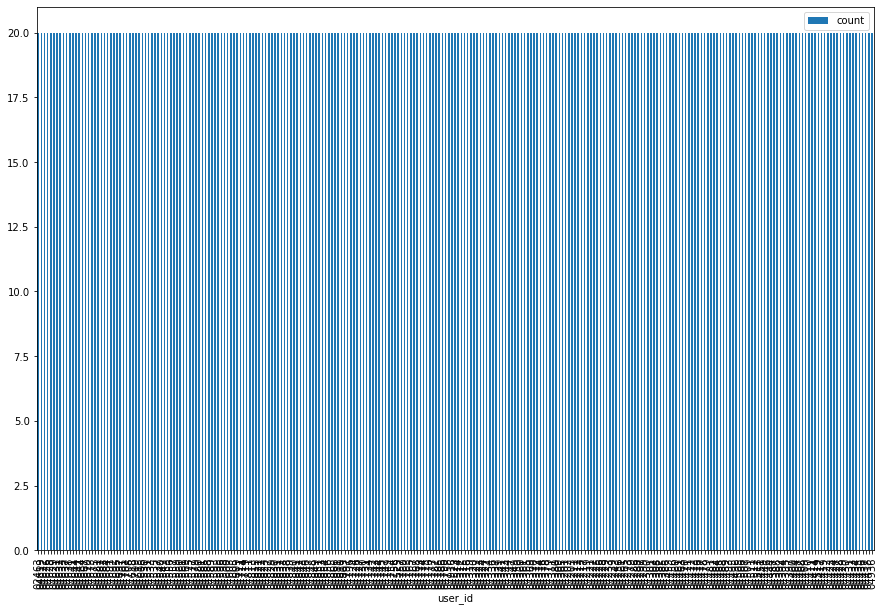

In [53]:
(
    subset_directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [54]:
subset_directory_df.head()

,user_id,user_img_id,path
241,04203,526,frgc32x32\04203d526.png
1691,04324,250,frgc32x32\04324d250.png
4550,04460,210,frgc32x32\04460d210.png
6365,04542,86,frgc32x32\04542d86.png
3756,04424,205,frgc32x32\04424d205.png


In [55]:
num_classes = len(subset_directory_df['user_id'].unique())

In [56]:
folder_list = []
tmp = []

for _, row in subset_directory_df.iterrows():
    if row['user_id'] not in tmp:
        tmp.append(row['user_id'])
    idx = tmp.index(row['user_id'])
    if idx >= len(folder_list):
        folder_list.append([row])
    else:
        folder_list[idx].append(row)


cat_list = [] # category of each image
x = [] # images
y = [] # labels
y_label = 0

for folder_name in tqdm(folder_list, desc='loading images'):
    tmp = []
    for file in folder_name:
        tmp.append(len(x))
        img = cv2.imread(file['path'],0)
        img = cv2.resize(img, (32,32))
        img = np.expand_dims(img, -1)
        x.append(img)
        y.append(y_label)
    y_label+=1
    cat_list.append(tmp)

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)

print('X, Y shape', x.shape, y.shape, cat_list.shape)


loading images:   0%|          | 0/265 [00:00<?, ?it/s]

X, Y shape (5300, 32, 32, 1) (5300,) (265, 20)


---

# Load and preprocess --> [train, val]

In [57]:
train_test_split = 0.7
no_files_per_class = 20

train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'classes for training and', test_size, ' classes for testing')

train_files = train_size * no_files_per_class

#Training Split
x_train = x[:train_files]
y_train = y[:train_files]
cat_train = cat_list[:train_size]

#Validation Split
x_val = x[train_files:]
y_val = y[train_files:]
cat_test = cat_list[train_size:]

print('X&Y shape of training data :',x_train.shape, 'and', y_train.shape, cat_train.shape)
print('X&Y shape of testing data :' , x_val.shape, 'and', y_val.shape, cat_test.shape)

185 classes for training and 80  classes for testing
X&Y shape of training data : (3700, 32, 32, 1) and (3700,) (185, 20)
X&Y shape of testing data : (1600, 32, 32, 1) and (1600,) (80, 20)


---
# Build the model

In [58]:
input_shape = (32,32,1)
print(input_shape)
left_input = Input(input_shape)
right_input = Input(input_shape)

(32, 32, 1)


In [59]:
W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

In [76]:
#Define Model

model = Sequential()
model.add(Conv2D(64, (6,6), activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(48, activation='sigmoid', kernel_initializer=W_init, bias_initializer=b_init))

encoded_l = model(left_input)
encoded_r = model(right_input)
          
subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(subtracted)
siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

optimizer= Adam(learning_rate=0.05)
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)

In [61]:
siamese_net.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 512)          1772480     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
subtract_2 (Subtract)           (None, 512)          0           sequential_2[0][0]         

---
# Train

In [62]:

def get_batch(batch_size=64):

    temp_x = x_train
    temp_cat_list = cat_train
    start=0
    end=train_size
    batch_x=[]

    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)

    class_list = np.random.randint(start, end, batch_size)
    batch_x.append(np.zeros((batch_size, 32, 32, 1)))
    batch_x.append(np.zeros((batch_size, 32, 32, 1)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]
        #If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]

        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]

    return(batch_x, batch_y)

In [72]:
def nway_one_shot(model, n_way, n_val):

    temp_x = x_val
    temp_cat_list = cat_test
    batch_x=[]
    x_0_choice=[]
    n_correct = 0

    class_list = np.random.randint(train_size+1, len(folder_list)-1, n_val)

    for i in class_list:
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 32, 32, 1)))
        temp.append(np.zeros((n_way, 32, 32, 1)))
        for k in range(0, n_way):
            temp[0][k] = x[j]

            if k==0:
                #print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
                #print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]
        result = siamese_net.predict(temp)
        result = result.flatten().tolist()
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(result)
    print(n_correct, "correctly classified among", n_val)
    accuracy = (n_correct*100)/n_val
    return accuracy


In [77]:
epochs = 30000
n_way = 20
n_val = 100
batch_size = 64

loss_list=[]
accuracy_list=[]
for epoch in tqdm(range(1,epochs), desc='training'):
    batch_x, batch_y = get_batch(batch_size)
    loss = siamese_net.train_on_batch(batch_x, batch_y)
    loss_list.append((epoch,loss))
    if epoch%50 == 0:
        print('Epoch:', epoch, ', Loss:',loss)
    if epoch%250 == 0:
    # if epoch%100 == 0:
        print("=============================================")
        accuracy = nway_one_shot(model, n_way, n_val)
        accuracy_list.append((epoch, accuracy))
        print('Accuracy as of', epoch, 'epochs:', accuracy)
        print("=============================================")
        if(accuracy>99):
            print("Achieved more than 90% Accuracy")
            #break



training:   0%|          | 0/29999 [00:00<?, ?it/s]

Epoch: 50 , Loss: 0.9765794277191162
Epoch: 100 , Loss: 0.8308022618293762
Epoch: 150 , Loss: 0.75859135389328
Epoch: 200 , Loss: 0.7251715660095215
Epoch: 250 , Loss: 0.7089513540267944
[0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896, 0.5000001192092896]
100 correctly classified among 100
Accuracy as of 250 epochs: 100.0
Achieved more than 90% Accuracy
Epoch: 300 , Loss: 0.7010514140129089
Epoch: 350 , Loss: 0.697208821773529
Epoch: 400 , Loss: 0.6953230500221252
Epoch: 450 , Loss: 0.6943730711936951
Epoch: 500 , Loss: 0.6938729882240295
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
100 correctly classifi

KeyboardInterrupt: 